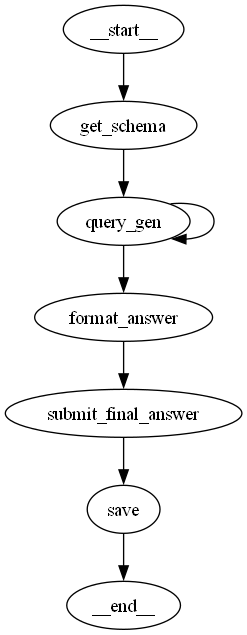

In [1]:
# Import and display graph
from IPython.display import Image, display
import graphviz
from my_agent import create_graph

# Create graph instance
app = create_graph()

# Convert to graphviz
dot = graphviz.Digraph()
for node in app.get_graph().nodes:
    dot.node(str(node))
for edge in app.get_graph().edges:
    dot.edge(str(edge[0]), str(edge[1]))

# Display
display(Image(dot.pipe(format='png')))